# Hyperparameter Optimization for MNIST Digit Classifcation

Most machine learning models have some parameters that you can play around with. We saw this last week with ridge regression. We were able to choose the value of $\lambda$ in order to get our model to behave differently. However one may ask the question, how do we know the best $\lambda$ for our model? This often depends on many factors and is model dependent. We will be answering this question for a different set of hyper parameters for a different model.

In this notebook, we will be using various different tools we have learned in past weeks and explore how to optimize their hyper parameters.

We will be importing a python module that includes the MNIST handwritten digit dataset for us. In addition we will use skleran's MLPClassifier as our MLP.

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import random

Now we load the data, which is already split into training and testing for us. However, we need to introduce a validation set anyways, so let us just append this into one huge data matrix X and label vector y. We will split this up very soon.

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
X = np.vstack((train_X, test_X))
y = np.append(train_y, test_y)

It is always a good idea to attempt to visualize data before performing any sort of ML techniques on it. Let us choose a few random indices and display the handwritten digits using the plt.imshow function.

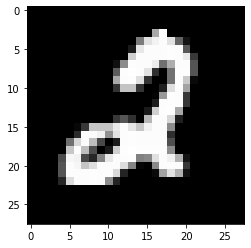

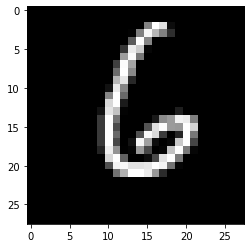

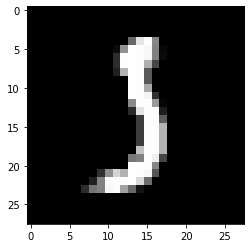

In [3]:
imgplot = plt.imshow(X[381], cmap = 'gray')
plt.figure()
imgplot = plt.imshow(X[32], cmap = 'gray')
plt.figure()
imgplot = plt.imshow(X[132], cmap = 'gray')

We notice that each data point is an image of size 28x28. However, we wish to have our data in 1 dimension. So, impliment the following function to flatten the entire data matrix X which has shape N X 28 X 28 to a new data matrix **X_flat** with shape N X $28^2$.

### **(TODO) Impliment the flatten_image_matrix function that takes in a data matrix X with input shape (N, 28, 28) to a flattened X with ouput shape (N, 28*28). (HINT: Use np.reshape!)**

In [4]:
def flatten_image_matrix(X_image):
    #TODO
    #Start
    return X_image.reshape(X_image.shape[0], X_image.shape[1] * X_image.shape[2])
    #End
    
X_flat = flatten_image_matrix(X_image=X)

To start off, let us take a scenario where we only wish to classify between a handwritten '0' and '1'. So, for this code, we wish to populate the variables $train\_X\_bin, train\_y\_bin, test\_X\_bin, test\_y\_bin, val\_X\_bin, val\_y\_bin$. Before we populate these variables, let us augment X_flat and y such that they only contain images with labels 0 or 1:

### **(TODO) Impliment the label_selector function. It will take in a list of labels to keep, and return the data matrix X_bin and label vector y_bin with only the desired labels. In addition, make sure that label '0' corresponds to -1 and label '1' coresponds to 1.**

In [5]:
def label_selector(X_all_labels, y_all_labels, labels_to_keep = []):
    X_new = []
    y_new = []
    #TODO
    #Start
    for i in range(len(y_all_labels)):
        if y_all_labels[i] in labels_to_keep:
            y_new.append(2 * y_all_labels[i] - 1)
            X_new.append(X_all_labels[i])
    X_new = np.array(X_new)
    y_new = np.array(y_new)
    #End
    return X_new, y_new


X_bin, y_bin = label_selector(X_flat, y, labels_to_keep = [0, 1])

And finally, our last function for data management is to take in our data and split it into a train set, a validation set, and a test set. Here is a breif discription of what each set is used for:

**Train Set**: This set is used to train our models on the MNIST data. This usually is a large chunk of the total data. Here, we are allocating 70% of the total data to train out model.

**Validation Set**: This set is used to tune our hyper parameters. So, for example, if we use a ridge regression model, we would train the model on the training set, and then tune lambda such that it minimizes the error in the validation set. 

**Test Set**: This set is used purely to benchmark our model. We do not train nor tune on this set. We only use it to compare out predicted output on the test set.

### **(TODO) Your job is to impilment the train_val_test_split function which takens in the data X matrix and y vector and splits it into 3 sets.**

In [6]:
def train_val_test_split(X, y, train_r = 0.5, val_r = 0.2, test_r = 0.3):
    #These are the variables we are returning
    train_X, train_y = None, None
    val_X, val_y = None, None
    test_X, test_y = None, None
    
    #Define the number of training, val, and testing data points
    N = len(y)
    N_train = int(N * train_r)
    N_val = int(N * val_r)
    N_test = int(N * test_r)
    
    #TODO
    #Start
    train_X = X[:N_train]
    train_y = y[:N_train]
    val_X = X[N_train:N_train + N_val]
    val_y = y[N_train:N_train + N_val]
    test_X = X[N_train + N_val:]
    test_y = y[N_train + N_val:]
    #End
    
    return train_X, train_y, val_X, val_y, test_X, test_y

train_X_bin, train_y_bin, val_X_bin, val_y_bin, test_X_bin, test_y_bin = train_val_test_split(X_bin, y_bin)

If we wish to classify a new datapoint $\vec{x_{new}}$, then we use the folowing scheme: $label_{new} = f(\vec{x_{new}}^T \vec{w}^*)$ where $\vec{w}^*$ is a learned parameter and $f(x) = 1$ if $x > 0$ and $f(x) = 0$ if $x \le 0$.

We now wish to define our loss function. Say we have two labels which are in fact just vectors. Since the lables only hold 0s and 1s, our loss function just simply return the amount of differences between the two labels. Or more formally:

$$
loss\_func(\vec{y_{pred}}, \vec{y_{ref}}) = \frac{1}{len(\vec{y_{pred}})}\sum_{y_{pred, i} \ne y_{ref, i}}1
$$

Or, if $y_{ref, i}$ and $y_{pred, i} \in  {0, 1}$ then:


$$
loss\_func(\vec{y_{pred}}, \vec{y_{ref}}) = \frac{1}{len(\vec{y_{pred}})}\sum_{i = 1}^{len(\vec{y_{pred}})} (y_{pred, i} - y_{ref, i})^2 
$$


### **(TODO) Impliment the function loss_func code. This loss function will simply return the percentage of missclassified datapoints given a test data matrix X_test, the optimal weight w_opt, and the reference labels y_ref (HINT: Use the previous functions).**

In [7]:
def loss_func(y_pred, y_ref):
    #TODO
    #Start
    err_vec = (y_pred - y_ref) ** 2
    return np.sum(err_vec) / len(err_vec)
    #End

### **(TODO) Impliment the classify function. Upon a scalar input, classify(x) will return the sign of x. On a vector input, classify(x) returns the sign of each element of the vector.**

In [8]:
def classify(x):
    #TODO
    #Start
    return 2*(x >= 0).astype(int) - 1
    #End

# MNIST: Ridge Classifer

Now we will try various different machine learning aproaches to classify the handwritten digits. For each of these ML techniques, we will introduce a hyper parameter and have you find the best hyper parameter. Let us start with ridge regression.

We have used ridge regression before, but let's remind ourselves how it works. Say we have a data matrix $X \in \mathbb{R}^{n \times d}$. In our case, $n$ is the number of training data for the '0' or '1' handwritten digits. Each image is $28 \times 28$ pixels, which means that $d = 28^2 = 784$. Our labels will be stored in a vector $\vec{y} \in \mathbb{R}^n$ where $y_i \in \{0, 1\}$. In ridge regression, we solve the following optimization problem: 

$$
\min_{\vec{w} \in \mathbb{R}^d} ||(X\vec{w} - \vec{y})||_2^2 + \lambda ||\vec{w}||_2^2, \; \; \lambda > 0
$$
Where the solution to this optimization problem is $\vec{w}^* = (X^TX + \lambda I)^{-1}X^T\vec{y}$. If we wish to classify a new datapoint $\vec{x_{new}}$, then we use the folowing scheme: $label_{new} = f(\vec{x_{new}}^T \vec{w}^*)$ where $f(x) = 1$ if $x > 0$ and $f(x) = 0$ if $x \le 0$. Now that we have covered how we will use ridge regression to classify new samples, let us impliment a few helper functions.

### **(TODO) Impliment the classify_ridge function. This function will take in the train/reference data along with the ridge hyper parameter. It should return the classification test error. You can use Sklearn's ridge model.**

In [ ]:
def classify_ridge(X_train, y_train, X_ref, y_ref, lambd):
    """
        X_ref and y_ref represent a data set that we compare the training set to.
        That is, we first train our model on X_train and y_train. Then we find a predicted
        output by feeding X_ref into our model. Finally, we compare this predcited
        output to y_ref. The error between the predicted and the reference will be 
        our error, which we return.
    """
    #TODO
    ridge = Ridge(alpha=lambd, solver='cholesky')
    #Start
    ridge.fit(X_train, y_train)
    y_pred = classify(ridge.predict(X_ref))
    return loss_func(y_pred, y_ref)
    #End

So we have a ridge classification function. Now, impliment a hyper-parameter grid search and random search over the powers of 10 to find the most optimal value of lambda. We will provide the $\lambda$ values. Make sure to grid search over the validation data. That is, we pass in the validation set for X_ref and y_ref.


### **(TODO) Given the EMPTY list err_lst, and err_list_rand iterate through all the lambdas and populate the errors lists. Make sure to populate err_lst, err_list_rand with the validation errors. We will use this list later for plotting.**

In [ ]:
#TODO
err_lst  = []
lambda_vals = np.logspace(-1, 12, 500)
#Start
for lambd in lambda_vals:
    loss = classify_ridge(X_train=train_X_bin, y_train=train_y_bin, X_ref=val_X_bin, y_ref=val_y_bin, lambd=lambd)
    err_lst.append(loss)
#End

In [ ]:
#TODO
err_lst_rand = []
lambda_vals_rand = (10 ** 12 - 10 ** -1) *  np.random.random(500) + 10 ** -1
#Start
for lambd in lambda_vals_rand:
    loss = classify_ridge(X_train=train_X_bin, y_train=train_y_bin, X_ref=val_X_bin, y_ref=val_y_bin, lambd=lambd)
    err_lst_rand.append(loss)
#End

In [ ]:
plt.loglog(err_lst_rand)

Now we will see how the validation error varies with the number of iterations for random search and how it varies with the values of lambda for grid search. 

### **(TODO) Plot the log of the validation errors values against the values of lambda for grid search and against the number of iterations for random search **

In [ ]:
#TODO PLOT log of errors vs log of lambda_vals 
#Hint: Use plt.loglog()
#Start
plt.loglog(lambda_vals, err_lst)
plt.xlabel('$log_{10}(\lambda)$')
plt.ylabel('$log_{10}(validation error)$')
plt.title('Log Lambda vs Log Validation Error')
#End

#Display the minimum error and lambda:
i_min = np.argmin(err_lst)
best_lambda = lambda_vals[i_min]
print("Best Lambda:",  format(best_lambda, '10.2E'))
print("Minimum Validation Error:",  err_lst[i_min])

In [ ]:
#TODO PLOT log of errors vs log of iterations 
#Hint: Use plt.loglog()
#Start
plt.loglog(err_lst_rand)
plt.xlabel('$log_{10}(Number_of_Iterations)$')
plt.ylabel('$log_{10}(validation error)$')
plt.title('Log Validation Error vs Log of Iterations')
#End

#Display the minimum error and lambda:
i_min = np.argmin(err_lst_rand)
best_lambda = lambda_vals_rand[i_min]
print("Best Lambda:",  format(best_lambda, '10.2E'))
print("Number of Iterations Taken for Best Lambda:", i_min)
print("Minimum Validation Error:",  err_lst_rand[i_min])

### **(TODO) Given the plots above, what are the most optimal values of lambda for each search method? What are the associated validation errors? Remember that this error is the percentage of miss-classified test points.**

COMMENT HERE

Based on the grid search that we have coded, $\lambda^*_{grid} \approx 2 * 10^8$ and $error_{grid} \approx 0.81\%$.
Based on the random search that we have coded, $\lambda^*_{random} \approx 9.17 * 10^8$ and $error_{random} \approx 1.7\%$
(Your random values may vary compared to ours).

As you may have observed, the values that were returned differed between grid search and random search. However, based on the values you returned from random search, you may have seen a better or worse validation error than with grid search. Some things to consider are as follows: If you were able to find a better or similar validation error with random search, consider how many iterations it took to find that value of lambda. Chances are that it was found in significantly less than the 500 iterations we ran both for. We hope this illustrates one of the key considerations when choosing between grid and random search. In some scenarios, it might be worth sacrificing a little bit of accuracy for greatly reducing the the computational complexity. However, you are not guarnteed the optimal value with random search. Especially in lower dimensional problems, grid search will always give you the optimal solution, assuming your grid is fine enough. However, grid search becomes very expensive as the dimensionality of the problem increases, which we will see later on in the notebook. 

### **(TODO) Using the lambda found in grid search from the pervious part, report the test error using this value of lambda. Comment on how good ridge regression is for binary classifcation of handwritten digits**

In [ ]:
#TODO
#Start
test_error = classify_ridge(train_X_bin, train_y_bin, test_X_bin, test_y_bin, lambd = best_lambda)
#End

print("Test Error:", test_error)

COMMENT

Our Test Error was less than 1%. This tells us that ridge regression is a very good for binary classification of MNIST data!

# MNIST: Logistic Regression With a Twist

Now we will perform the same sort of classification, except we will use logistic regression. With a twist. Before we get to the twist, let us perform the standard logistic regression. You may use sklearn's logistic regression functionality. Remember, we are classifying on the following variables:

$$train\_X\_bin, train\_y\_bin, test\_X\_bin, test\_y\_bin$$


### **(TODO) Perform logistic regression on the MNIST data. Sklearn's LogisticRegression model may be useful here. Make sure to use  LogisticRegression(penalty = 'none', solver='saga')**

In [ ]:
#TODO
#Start
logreg = LogisticRegression(penalty='none', solver='saga')
logreg.fit(train_X_bin, train_y_bin)
#End

### **(TODO) Report the training and testing error. You can re-use the loss_func function from before .** 

In [ ]:
#TODO
#Start
train_y_pred = logreg.predict(train_X_bin)
test_y_pred  = logreg.predict(test_X_bin)

train_error = loss_func(train_y_pred, train_y_bin)
test_error = loss_func(test_y_pred, test_y_bin)
#End

print('Training Error:', train_error)
print('Testing  Error:', test_error)

### **(TODO) Comment on how well logistic regression performs on binary MNIST digit classification**

COMMENT

Logistic regression works very well on the handwritten digits. The training is near perfect and the testing only has a mislcassifcation rate of 0.2%

Seeing how logistic regression performs so well, we will not try our best to make it perform worse. The way we will do this is to add noise to the training data. We will then see how well it performs at different noise levels.

Some background first: We can model noise by simply adding small random numbers to each entry of our matrices. There is much theory behind how to model this noise using random variables, but we will not dive into this. We will provide you with the code that adds noise to the data. The one thing you must understand is that we will be using a parameter, named sigma, that will control the level of noise added. 

To get a feel for this, let us first plot a simple sine wave without any added noise

In [ ]:
t = np.arange(500)
plt.plot(t, np.sin(10 * 2 * np.pi * t / len(t)))


plt.title('Simple Sine Wave')

Now that we have plotted a sine wave, we will add noise to it with this parameter we have mentioned before, sigma. We want you to play around with sigma. Try differnt values of sigma and run the cell below. This will give you a feel for how this parameter changes added noise. Do note that $\sigma \ge 0$. You should specifically try values between 0 and 1

### **(TODO) Play around with sigma to get a feel for how noise effects the data.** 

In [ ]:
#Try different sigma values 0 - 1
#Start
sigma = 0.2
#End

noisy_sine = np.sin(10 * 2 * np.pi * t / len(t)) + np.random.normal(0, sigma, len(t))
plt.plot(t, noisy_sine)
plt.title('Noisy Sine Wave $\sigma=$' + str(sigma))

Now, we will do the same thing for our datasets. First, we create a function that takes in the train/val/test data images and adds noise to them. The noise paramter is sigma.

In [9]:
def noisy_data(X_train, X_val, X_test, sigma):
    X_train_noisy = X_train + np.random.normal(0, sigma, X_train.shape)
    X_val_noisy = X_val     + np.random.normal(0, sigma, X_val.shape)
    X_test_noisy  = X_test  + np.random.normal(0, sigma, X_test.shape)
    return X_train_noisy, X_val_noisy, X_test_noisy

We also need a function to convert the 1D flattened images back to 2D. This you will impliment:

### **(TODO) Impliment the function vec_to_img which takes in a 1d array and the image resolution. It will return a 2d array that represents the image.** 

In [10]:
def vec_to_img(vec, res):
    #TODO
    #Start
    return vec.reshape(res)
    #End

Now let us define our new noisy dataset. We will be plotting a few handwritten digits. We encourage you to again play with sigma and see how the images turnout:

In [ ]:
#Try different sigma values in the range 0-400
#Start
sigma = 200
#End

#Generate the noisy data
X_train_noisy, X_val_noisy, X_test_noisy = noisy_data(train_X_bin, val_X_bin, test_X_bin, sigma)
#pick random indices
random_indices = random.sample(range(0, X_train_noisy.shape[0] - 1), 5)
for i in random_indices:
    imgplot = plt.imshow(vec_to_img(X_train_noisy[i], (28, 28)), cmap = 'gray')
    plt.title('Label = ' + str((train_y_bin[i] + 1) // 2))
    plt.figure()

Now we will see how logistic regression performs at different values of sigma. We will provide you a range of sigma values: $\sigma \in [0, 100]$. We would like you to populate the list $err\_lst$. For each value of sigma, find the error and update the list:

### **(TODO) Go through all the values of sigma in sigmas. Populate the list err_lst with the error on the noisy test data for specific values of sigma. Use loss_func to compute the error.** 

In [ ]:
sigmas = np.arange(0, 450, 50)
err_lst = []
#TODO
#Start
logreg = LogisticRegression(penalty='none', solver='saga')
for sigma in sigmas:
    #Generate the noisy data
    X_train_noisy, X_val_noisy, X_test_noisy = noisy_data(train_X_bin, val_X_bin, test_X_bin, sigma)
    #Fit the logistic regressor
    logreg.fit(X_train_noisy, train_y_bin)
    #predict
    y_pred = logreg.predict(X_test_noisy)
    #find and store the error
    err_lst.append(loss_func(y_pred, test_y_bin))
#End

### **(TODO) Now plot the error as a funtion of sigma below.**

In [ ]:
#TODO
#Start
plt.plot(sigmas, err_lst)
#End

error_400 = err_lst[-1]
print("Test Error at sigma = 400:",  format(error_400 * 100, '10.2f') + '%')

We can see the error start creeping up, as expected. So, we will try to combat this by introducing a hyperparameter for regularization. Just like in ridge regression where we used lambda, logistic regression also has a regularization hyper parameter. We will be using the L2 regularizer to see if we can achieve better results at high error.

Let us first show you how to use the regularizer with Sklearn's regressor:

In [ ]:
c = 23.0
logreg = LogisticRegression(random_state=0, penalty = 'l2', solver='saga')
logreg.set_params(C=c)

Here, the parameter $c$ is used as the hyper parameter to control the L2 regularization. The larger $c$ is, the smaller the regularization is. That is, $c$ is inversley proportional to the amount of regularization (unlike ridge regression).  

So, we will now use $\sigma = 400$ and try different values of $C$. We will then compare the test error with the best value of C (tuned via the validation set) to the test error with no regularization

### **(TODO) Perform hyper parameter optimization via grid search. Use sigma = 400 and try all values of C within the range specified. Store the error in err_lst for each value of C**

In [ ]:
Cs = np.logspace(-15, -1, 10)
err_lst = []
X_train_noisy, X_val_noisy, X_test_noisy = noisy_data(train_X_bin, val_X_bin, test_X_bin, sigma=400)
logreg = LogisticRegression(random_state=0, penalty = 'l2', solver='saga')
#TODO
#Start
for c in Cs:  
    #Set the parameter
    logreg.set_params(C=c)
    #Fit the logistic regressor
    logreg.fit(X_train_noisy, train_y_bin)
    #predict
    y_pred = logreg.predict(X_val_noisy)
    #find and store the error
    err_lst.append(loss_func(y_pred, val_y_bin))
#End

### **(TODO) Plot the validation error against the different values of C.**

In [ ]:
#TODO
#Start
plt.semilogx(Cs, err_lst)
plt.title('log(C) vs Validation Error')
plt.ylabel('Validation Error')
plt.xlabel('log(C)')
#End

#Display the minimum error and lambda:
i_min = np.argmin(err_lst)
best_C = Cs[i_min]
print("Best C:",  format(best_C, '10.2E'))
print("Minimum Validation Error:",  format(err_lst[i_min] * 100, '10.2f') + '%')

### **(TODO) Which value of C is the best? What is the associated error?.**

COMMENT

C should be on the order of $10^{-8}$ and the associated error should be around 0.15.

Now we are going to find the test error at this optimal value best_C. 

### **(TODO) Find the test error at the optimal value best_C. Compare this to the value error_400, the test error with no regularization at sigma = 400.**

In [ ]:
logreg = LogisticRegression(random_state=0, penalty = 'l2', solver='saga')
test_error_logreg = None
#TODO
#Start
#Set to the optimal hyper-paremter
logreg.set_params(C=best_C)
#Fit the logistic regressor
logreg.fit(X_train_noisy, train_y_bin)
#predict
y_pred = logreg.predict(X_test_noisy)
#find the test error
test_error_logreg = loss_func(y_pred, test_y_bin)
#End

print("Test Error With Best Hyperparameter:", format(test_error_logreg * 100, '10.2f') + '%')
print("Test Error With No Hyperparameter:", format(error_400 * 100, '10.2f') + '%')

### **(TODO) Is this minimum error better than the error without regularization? If so, comment on why you think this is.**

COMMENT

Yes, we achieved a lower error using the right hyper parameter! This is because L2 regularization if very good when our samples have noise. L2 regularization will pick out solutions with a small norm, which in turn helps us filter out some of the noise.

# **TEST START**

In [27]:
X_train_noisy, X_val_noisy, X_test_noisy = noisy_data(train_X_bin, val_X_bin, test_X_bin, sigma=400)
X_img_train = np.zeros((len(X_train_noisy), 28, 28))

k = 10 
pca = PCA(n_components=k)
for i in range(len(X_train_noisy)):
    X = vec_to_img(x, (28, 28))
    X_img_train[i] = 


(7390, 784)
(7390, 28, 28)


# **TEST END**

# MNIST: Least Squares - PCA On Noisy Data

We will finally use Least Squares in combination with PCAs. Let us mathematically define our model:

Remember that PCA requires de-meaned data. Or, mathematically:

$$
    \hat{\vec{x}} = \frac{1}{n}\sum_{i = 1}^n \vec{x_i}\\
    \hat{X} = X - \hat{\vec{x}}
$$

We have slightly abused notation. When we write $X - \hat{\vec{x}}$, we are refering to subtracting the row average of $X$ from each row of $X$. This will give us a zero mean version of $X$, which we call $\hat{X}$. 

Now our model looks like:

$$\vec{w}^* = \arg\min_{\vec{w} \in \mathbb{R}^k} ||X_k\vec{w} - \vec{y}||_2^2 \\
X_k = PCA_k(X) = \hat{X}V_k, \; \; \hat{X} = U \Sigma V^T$$

We define $V_k$ to be the first $k$ columns of $V$. In this problem, k is our hyper parameter. 
Then, to classify, we use:

$$
    PCA_k(X_{new}) \vec{w}^* = \hat{X_{new}}V_{k,new} \vec{w}^*
$$

We wish to explore which value of k will yield us the best results.

First, we need a least squares function and a PCA funtion. You can use Sklearn's implimentation of each.

### **(TODO) Impliment the least_sq_pca_train function. This will perform least squares on the k dimensional representation of the data matrix X. Return the weight vector and the training error**

In [11]:
def least_sq_pca_train(X_train, y_train, k):
    #TODO
    #Start
    pca = PCA(n_components=k)
    pca.fit(X_train)
    Xk = pca.transform(X_train)
    w = np.linalg.lstsq(Xk, y_train,rcond=None)[0]
    y_pred = classify(Xk @ w)
    train_err = loss_func(y_pred, y_train)
    #End
    return w, train_err

### **(TODO) Impliment the least_sq_pca_test function. This will first perform k-PCA on the test data, then multiplies the k-PCA test data with the optimal vector w. Report the predicted value and the testing error**

In [12]:
"""
    We use the convention "ref" since X_ref and y_ref can represent the 
    testing or validation data, each used as a reference data set
"""
def least_sq_pca_ref(X_ref, y_ref, w, k):
    #TODO
    #Start
    pca = PCA(n_components=k)
    pca.fit(X_ref)
    Xk = pca.transform(X_ref)
    y_pred = classify(Xk @ w)
    ref_err = loss_func(y_pred, y_ref)
    #End
    return y_pred, ref_err

Before we evaluate our Least Squares PCA model, let us first just use standard least squares on the noisy dataset. We will use $\sigma = 400$ again.

### **(TODO) Train a standard least squares model on the noisy training set, and report the error on the noisy testing set.**

In [19]:
X_train_noisy, X_val_noisy, X_test_noisy = noisy_data(train_X_bin, val_X_bin, test_X_bin, sigma=400)
#TODO
#Start
w = np.linalg.lstsq(X_train_noisy, train_y_bin,rcond=None)[0]
y_pred = classify(X_test_noisy @ w)
test_err_OLS = loss_func(y_pred, test_y_bin)
#End

print('Ordinary Least Squares Testing Error:', format(test_err_OLS * 100, '10.2f') + '%')

Ordinary Least Squares Testing Error:      16.42%


It seems that the OLS testing error on the noisy data-set is roughly 15%. Let us see if we can do better with our K-PCA-OLS functions.

Now (hopefully we are seeing a pattern by now) we want to use hyper-parameter grid search in order to find the best k. We have provided the range of Ks for you to use. 

### **(TODO) Iterate through all values of k in the range in order to fit the model on the noisy training data. Then, find the validation error error at each value of k. Store this validation error into the list err_lst**

In [ ]:
ks = range(1, 784, 10)
err_lst = []
#TODO
#Start
for k in ks:
    w, train_err = least_sq_pca_train(X_train_noisy, train_y_bin, k = k)
    y_pred, val_err = least_sq_pca_ref(X_val_noisy, val_y_bin, w, k = k)
    err_lst.append(val_err)
#End

### **(TODO) Plot the values of k vs the err_lst**

In [ ]:
#TODO
#Start
plt.scatter(ks, err_lst)
plt.xlabel('K')
plt.ylabel('Validation Error')
plt.title('K vs Validation Error $\sigma = 400$')
#End

It seems that the best values of k happen in the beginning. Let us 'thin the herd' and change the range from (1, 100, 5)

### **(TODO) Copy what you have done for the previous part, this time the range is slightly different**

In [ ]:
ks = range(1, 100, 10)
err_lst = []
#TODO
#Start
for k in ks:
    w, train_err = least_sq_pca_train(X_train_noisy, train_y_bin, k = k)
    y_pred, val_err = least_sq_pca_ref(X_val_noisy, val_y_bin, w, k = k)
    err_lst.append(val_err)
#End

### **(TODO) Plot the values of k vs the err_lst (Copy from before)**

In [ ]:
#TODO
#Start
plt.plot(ks, err_lst)
plt.xlabel('K')
plt.ylabel('Validation Error')
plt.title('K vs Validation Error $\sigma = 400$')
#End

It seems like we still need to narrow our focus down to everything below 20. Let us change the range yet again:

### **(TODO) Copy what you have done for the previous part, this time the range is slightly different**

In [ ]:
ks = range(1, 20, 1)
err_lst = []
#TODO
#Start
for k in ks:
    w, train_err = least_sq_pca_train(X_train_noisy, train_y_bin, k = k)
    y_pred, val_err = least_sq_pca_ref(X_val_noisy, val_y_bin, w, k = k)
    err_lst.append(val_err)
#End

### **(TODO) Plot the values of k vs the err_lst (Copy from before)**

In [ ]:
#TODO
#Start
plt.plot(ks, err_lst)
plt.xlabel('K')
plt.ylabel('Validation Error')
plt.title('K vs Validation Error $\sigma = 400$')
#End


#Display the minimum error and lambda:
i_min = np.argmin(err_lst)
best_k = ks[i_min]
print("Best K:",  format(best_k, '10.2E'))
print("Minimum Validation Error:",  format(err_lst[i_min] * 100, '10.2f') + '%')

And finally, we can see where our best performance happens! 

### **(TODO) Using best_k, find the noist testing error. Is it better than the standard least squares noisy testing error? If not, what does this tell us about the number of dimensions of our data? Do we need them all?**

In [ ]:
test_err_kpca = None
#TODO
#Start
w, train_err = least_sq_pca_train(X_train_noisy, train_y_bin, k = best_k)
print(w)
y_pred, test_err_kpca = least_sq_pca_ref(X_test_noisy, test_y_bin, w, k = best_k)
#End


print("Optimal K-PCA OLS Test Error:    ", format(test_err_kpca * 100, '10.2f') + '%')
print("Standard OLS (no PCA) Test Error:", format(test_err_OLS * 100, '10.2f') + '%')

COMMENT

We can see that standard OLS was not that different than the optimal K-PCA OLS. This tells us that we do not need to reduce the dimensionality, we need all the dimensions that we have. If anything, we can use higher dimension data. However, lowering the dimension does not help us here.

Notice the technique we used here. We used a grid search, but we did split it into multiple smaller grid searches. We broke it down into k = 1, 101, 201, ... 701 then we did k = 1, 11, 21, ... 91 then finally we did k = 1, 2, 3, ... 20. 

However, this 'augmented' grid search has it's advantages and disadvantages. Please list the pros and cons of this augmented grid search:

### **(TODO) Augmented grid search pros:**

COMMENT HERE

We are able to reach a minimum in a very small amount of time. We broke the problem into sizable chunks that were not very time consuming.

### **(TODO) Augmented grid search cons:**

COMMENT HERE

The biggest con to this is that we are assuming that there are no 'dips' in our graph. What we mean by 'dips' are any sharp drops in error. If there are dips, then iterating over every 100 hyperparemeter values may completeley jump over the dip.

### Using an MLP Classifier on the Noisy Data

So far you have experimented with grid search on the hyper parameters associated with ridge regression, logistic regression and PCA. Now, let us try the same thing on a multi layer perceptron classifier, a type of neural net. We will keep things somewhat simple by ommitting some of the parameters from the search since they will be covered more in-depth in the neural networks module. It is recommended that you are familiar with MLPs and to read through the neural networks section of the hyper paramter notes before beginning this part. We will be using sklearn's MLP classifer function along with its GridSearchCV functionality. 

In [ ]:
"""
We will begin by running the MLP classifer with its default parameters for 300 iteration to see how it performs. 
If you are curious you can check to see what the default parameters are on the sklearn.neural_netwrk.MLPClassifer 
documentation page (you will likely have to reference this page regardless to complete some of the code).
Again, you will not know what all of the parameters listed in the documentation do, some will be introduced 
in the neural nets module and others will be introduced in future, advanced coursework. 
"""

MLP = MLPClassifier(random_state = 1, max_iter = 100)   #Initialize the model
##TODO START
#Fit the model on the training data and then find the accuracy on the test set
MLP.fit(X_train_noisy, train_y_bin)
MLP.score(X_test_noisy, test_y_bin)
##TODO END

The default parameters are giving a pretty good result. Since our objective right now is to simply to do binary classification, this would make sense since the problem is not too complex. 

### **(TODO) Implement Sklearn grid search on the model**



We will use the GridSearchCV functions of Sklearn to try and find an optimal set of hyperparameters. We have already included the possible parameter values/ranges, you will simply have to feed them in. Since we assume you don't want to have to sit in your computer waiting for it to train, we've only included a few hyperparameters to test out. However, once you finish the assignment you should see that it is very easy to generalize to the other hyperparameters as well and you are encourgaed to experiment with different values/ranges/hyperparameters. Since you have already implemented grid search manually earlier with for loops, we will be using Sklearn here to gain exposure to it.

In [ ]:
#TODO
hidden_layer_sizes = [500]
activation_fxns = ['relu', 'tanh']
solvers = ['sgd', 'adam']
learning_rates = [0.1, 1]
#START
#Implement GridSearchCV 
parameters = {'hidden_layer_sizes':hidden_layer_sizes, 'activation': activation_fxns, 'solver' :solvers, 'learning_rate_init' :learning_rates}
grid_search = GridSearchCV(MLP, parameters, scoring = "accuracy", verbose = 10, cv = 2)
grid_search.fit(X_train_noisy, train_y_bin)
#END
#This took about 10 minutes to run, your time may vary depending on your computer

Recall earlier when we did comapred grid search and random search for ridge regression. It may have seemed trivial then since only one hyper parameter was being optimized, but hopefully you see now the potential issues with grid search. Even though we were running a very small problem with 8 combination of hyper parameters and only 100 iterations per combination, it took around 10 minutes. This is still very much considered a low dimensional problem. One can infer how computationally heavy it would become with much more data, features and combinations. In those cases, it may be more prudent to do a random search or an adaptive random search as described in the notes, in order to still get a good result using less computation. Hyperparameter optimization is still an area of ongoing research and interested students may look up research papers or look into other techniques such as Bayseian optimization. 